# Model for price prediction

## Random Forest

In the mid season check we got to a model able to predict price based on performance with a very decent accuracy. However, for a model to be functional as a real life predictor, it requies the price not to be only described by a state of the form

$\text{Price} = f(\text{Average, GP, Home}) + \epsilon \text{ Team},$

but by one that also takes information about the recent price itself to predict the price in the future:

$\text{Price} _t = f(\text{State} _t) + g(\text{Price} _{t-1}) + h(\text{Price} _{t-2}) + ... ,$
 
where $\text{State}_t$ corresponds to the current "frozen" performance statistics, the team, and other price-based features, such as volatility. This will capture more subtle effects on the market, such as opinion, transfer rumours, ...

Let's bring back our cleansed dataset:

In [1]:
import pandas as pd
df = pd.read_csv("../all_data.csv")

#Players who have played below the GP average of the dataset
below_avg_GP = (
    df.groupby("Player")["GP"]
      .max()
      .loc[lambda x: x < 4]
      .index
      .tolist()
)

df = df[~df["Player"].isin(below_avg_GP)]

#Rows before the season started
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Date"] > "15-08-2025"]
df.shape

(11125, 10)

Now, I'll create three new features: `Price_lag1`, `Price _lag2`, `Price_lag3`, `Price_lag4`, and `Price_lag5`, one for each time regression. Let's see how many rows without NA's are available after this.

In [2]:
df_t = df.sort_values(['Player', 'Date'])

# Price lags
df_t['Price_lag1'] = df_t.groupby('Player')['Price'].shift(1)
df_t['Price_lag2'] = df_t.groupby('Player')['Price'].shift(2)
df_t['Price_lag3'] = df_t.groupby('Player')['Price'].shift(3)
df_t['Price_lag4'] = df_t.groupby('Player')['Price'].shift(4)
df_t['Price_lag5'] = df_t.groupby('Player')['Price'].shift(5)

# Date lags
df_t['Date_lag1'] = df_t['Date'].shift(1)
df_t['Date_lag2'] = df_t['Date'].shift(2)
df_t['Date_lag3'] = df_t['Date'].shift(3)
df_t['Date_lag4'] = df_t['Date'].shift(4)
df_t['Date_lag5'] = df_t['Date'].shift(5)

# Day differences
df_t['d_lag1'] = (df_t['Date'] - df_t['Date_lag1']).dt.days
df_t['d_lag2'] = (df_t['Date'] - df_t['Date_lag2']).dt.days
df_t['d_lag3'] = (df_t['Date'] - df_t['Date_lag3']).dt.days
df_t['d_lag4'] = (df_t['Date'] - df_t['Date_lag3']).dt.days
df_t['d_lag5'] = (df_t['Date'] - df_t['Date_lag3']).dt.days

I'll drop every row containing NA's in the new columns:

In [3]:
lag_cols = [
    'Price_lag1', 'Price_lag2', 'Price_lag3', 'Price_lag4', 'Price_lag5',
    'd_lag1', 'd_lag2', 'd_lag3', 'd_lag4', 'd_lag5']

df_t = df_t.dropna(subset=lag_cols)

df_t.isna().sum().loc[lag_cols]

Price_lag1    0
Price_lag2    0
Price_lag3    0
Price_lag4    0
Price_lag5    0
d_lag1        0
d_lag2        0
d_lag3        0
d_lag4        0
d_lag5        0
dtype: int64

In [4]:
df_t.shape

(8975, 25)

I'll pick the features and target for Random Forest, since it's the model that worked the best in the mid season check.

In [5]:
X_rf = pd.get_dummies(
    df_t[['GP', 'Home', 'Average', 'Team', 'Price_lag1', 'Price_lag2', 'Price_lag3', #'Price_lag4', 'Price_lag5', 
          'd_lag1', 'd_lag2', 'd_lag3']],#, 'd_lag4', 'd_lag5']],
    drop_first=True
)


y_rf = df_t["Price"]

Data should now be split strictly by Date, since the lags would **definitely introduce data leakage**.

Obviously there's overfitting. Here's my analysis: each day the change in the price is actually really small, so the price from the day before already gives the model an almost perfect approach. How will I fix this? By changing price lags to price difference between those days; plus, I will change the target to $\Delta \text{Price}$ for the next day, not the price itself.

## Change of target: $\Delta$Price

Firts, I'll create the features based on differences:

In [6]:
#Compute differences

p = df_t.groupby('Player')['Price']

df_t['dPrice_1'] = p.diff(1)
df_t['dPrice_2'] = p.diff(2)
df_t['dPrice_3'] = p.diff(3)
df_t['dPrice_4'] = p.diff(4)
df_t['dPrice_5'] = p.diff(5)

# Shift date by -1 to get the "next price date"
df_t['Date_next'] = df_t.groupby('Player')['Date'].shift(-1)

# Compute number of days until next price
df_t['d_next'] = (df_t['Date_next'] - df_t['Date']).dt.days

# Target 1: Next price change
df_t['Price_diff_next'] = df_t.groupby('Player')['Price'].shift(-1) - df_t['Price']

# Target 2 (if target 1 does not work): daily price change (for differences greater than one day)
df_t['Price_diff_next_daily'] = df_t['Price_diff_next'] / df_t['d_next']

#Get rid of NA rows
fut_cols = ['Date_next', 'd_next', 'Price_diff_next', 'Price_diff_next_daily']

df_t = df_t.dropna(subset=fut_cols)

df_t.isna().sum().loc[fut_cols]

Date_next                0
d_next                   0
Price_diff_next          0
Price_diff_next_daily    0
dtype: int64

In [7]:
df_t.shape

(8545, 34)

I'll also add the volatility based on the last, a mean absolute change for each lag, and a change probability (jump) for each lag, all based in the last 5 entries available.

In [8]:
#Volatility based on the 5 most recent prices
df_t['Volatility'] = pd.concat(
    [df_t['Price'], df_t['Price_lag1'], df_t['Price_lag2'], df_t['Price_lag3']
     #, df_t['Price_lag4'], df_t['Price_lag5']
    ], axis=1).std(axis=1)

#Mean Change
df_t['dPrice_1_2'] = df_t['dPrice_1'] - df_t['dPrice_2']
df_t['dPrice_2_3'] = df_t['dPrice_2'] - df_t['dPrice_3']
df_t['dPrice_3_4'] = df_t['dPrice_3'] - df_t['dPrice_4']
df_t['dPrice_4_5'] = df_t['dPrice_4'] - df_t['dPrice_5']

diff_cols = ['dPrice_1', 'dPrice_1_2', 'dPrice_2_3']

df_t['MC'] = (
    df_t[diff_cols]
        .mean(axis=1)
)

#Jump

window = 3

df_t['Jump'] = ((df_t['dPrice_1'] != 0).astype(int)  + (df_t['Price_lag1'] - df_t['Price_lag2'] != 0).astype(int) + (df_t['Price_lag2'] - df_t['dPrice_3'] != 0).astype(int) 
                #+ (df_t['Price_lag3'] - df_t['dPrice_4'] != 0).astype(int) + (df_t['Price_lag4'] - df_t['dPrice_5'] != 0).astype(int)) 
               ) / window

#Get rid of NA rows
fut_cols_2 = ['Volatility', 'MC', 'Jump']

df_t = df_t.dropna(subset=fut_cols_2)

df_t.isna().sum().loc[fut_cols_2]

/tmp/ipykernel_608718/3092243923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['Volatility'] = pd.concat(
/tmp/ipykernel_608718/3092243923.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['dPrice_1_2'] = df_t['dPrice_1'] - df_t['dPrice_2']
/tmp/ipykernel_608718/3092243923.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

Volatility    0
MC            0
Jump          0
dtype: int64

In [9]:
df_t.shape

(8115, 41)

In [10]:
df_t.tail()

,Date,Team,Player,Position,Points,Price,GP,Home,Away,Average,...,d_next,Price_diff_next,Price_diff_next_daily,Volatility,dPrice_1_2,dPrice_2_3,dPrice_3_4,dPrice_4_5,MC,Jump
17404,2026-01-14,Arsenal,Ødegaard,Midfielder,83,10540000,15,8,7,5.53,...,1.0,50000.0,50000.0,545588.367422,-110000.0,-80000.0,-2630000.0,-1120000.0,263333.333333,1.000000
17975,2026-01-15,Arsenal,Ødegaard,Midfielder,83,10590000,15,8,7,5.53,...,2.0,100000.0,50000.0,613976.112456,-980000.0,-110000.0,-80000.0,-2630000.0,-346666.666667,1.000000
18545,2026-01-17,Arsenal,Ødegaard,Midfielder,83,10690000,15,8,7,5.53,...,2.0,-10000.0,-5000.0,527035.735664,-50000.0,-980000.0,-110000.0,-80000.0,-310000.000000,1.000000
19103,2026-01-19,Arsenal,Ødegaard,Midfielder,87,10680000,16,8,8,5.44,...,1.0,0.0,0.0,72341.781381,-100000.0,-50000.0,-980000.0,-110000.0,-53333.333333,1.000000
19666,2026-01-20,Arsenal,Ødegaard,Midfielder,87,10680000,16,8,8,5.44,...,2.0,-160000.0,-80000.0,46904.157598,10000.0,-100000.0,-50000.0,-980000.0,-30000.000000,0.666667


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

X_rf = pd.get_dummies(
    df_t[['GP', 'Home', 'Average', 'Team', 'd_lag1', 'd_lag2', 'd_lag3', 'dPrice_1', 'd_next',
          'dPrice_1_2', 'dPrice_2_3', 'Price', 'MC', 'Volatility'
         ]],
    drop_first=True
)

y_rf = df_t["Price_diff_next"]

# Sort by date
df_t_sorted = df_t.sort_values('Date')

# Use last 20% of dates as test
unique_dates = df_t_sorted['Date'].unique()
cutoff_date = unique_dates[int(0.8 * len(unique_dates))]

train = df_t_sorted[df_t_sorted['Date'] <= cutoff_date]
test  = df_t_sorted[df_t_sorted['Date'] > cutoff_date]

print("Train dates:", train['Date'].min(), "→", train['Date'].max())
print("Test dates:", test['Date'].min(), "→", test['Date'].max())

X_train = X_rf.loc[train.index]
X_test  = X_rf.loc[test.index]

y_train = y_rf.loc[train.index]
y_test  = y_rf.loc[test.index]

# Random Forest
rf = RandomForestRegressor(
    n_estimators=1000,      # number of trees
    max_depth=None,         # grow until leaves are pure or min_samples_split
    min_samples_leaf=1,     # minimum samples per leaf
    random_state=42,
    n_jobs=-1
)

# Fit
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"R²: {r2:.3f}, MAE: {mae:.2f}")

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X_rf.columns).sort_values(ascending=False)
print("\nFeature importances:")
print(importances)

Train dates: 2025-10-09 00:00:00 → 2026-01-15 00:00:00
Test dates: 2026-01-17 00:00:00 → 2026-01-22 00:00:00
R²: 0.189, MAE: 50032.06

Feature importances:
dPrice_1                       0.180078
Price                          0.121122
Average                        0.098105
d_next                         0.092601
dPrice_1_2                     0.081650
Volatility                     0.075647
MC                             0.069412
dPrice_2_3                     0.063317
GP                             0.041536
Home                           0.028913
d_lag1                         0.017208
Team_Manchester City           0.015593
d_lag2                         0.014922
Team_Newcastle                 0.011191
d_lag3                         0.010259
Team_Fulham                    0.008485
Team_Manchester United         0.007941
Team_Arsenal                   0.007848
Team_Liverpool                 0.007528
Team_Leeds United              0.007058
Team_Chelsea                   0.006981
Team

After some trials, I found those features to increase the accuracy of the model the most; and believe me, it can perform very poorly if they're not picked correctly. Notice that near the end I kept info of the last 3 days. That is because, when the window is increased to 5 days, it can go back too much in time, since the data collection has been irregular so far. I'll keep the data selection to go back in time 5 days anyways for now to see if it benefits the model when there's more data regularly saved and available.

Let's explore the new features a little:

In [14]:
new_features = df_t[['Price_lag1', 'Price_lag2', 'Price_lag3', 'Price_lag4', 'Price_lag5', 'd_lag1', 'd_lag2', 'd_lag3',
               'd_lag4', 'd_lag5', 'Date_next', 'd_next', 'Price_diff_next', 'Price_diff_next_daily',
                'dPrice_1', 'dPrice_2', 'dPrice_3', 'dPrice_4', 'dPrice_5',
                'dPrice_1_2', 'dPrice_2_3', 'dPrice_3_4', 'dPrice_4_5', 'Volatility', 'MC', 'Jump']]

new_features.describe()

/home/diego/myenv/lib/python3.12/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,Price_lag1,Price_lag2,Price_lag3,Price_lag4,Price_lag5,d_lag1,d_lag2,d_lag3,d_lag4,d_lag5,...,dPrice_3,dPrice_4,dPrice_5,dPrice_1_2,dPrice_2_3,dPrice_3_4,dPrice_4_5,Volatility,MC,Jump
count,8.115000e+03,8.115000e+03,8.115000e+03,8.115000e+03,8.115000e+03,8115.000000,8115.000000,8115.000000,8115.000000,8115.000000,...,7.255000e+03,6.827000e+03,6.399000e+03,7.685000e+03,7.255000e+03,6.827000e+03,6.399000e+03,8.115000e+03,8.115000e+03,8115.000000
mean,2.700975e+06,2.704293e+06,2.707719e+06,2.712343e+06,2.718678e+06,5.309673,10.612939,15.849908,15.849908,15.849908,...,-4.175052e+03,-3.606269e+03,-2.167526e+03,3.098243e+03,3.099931e+03,3.748352e+03,3.938115e+03,1.665539e+05,-2.978024e+02,0.896570
min,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,1.500000e+05,0.000000,1.000000,1.000000,1.000000,1.000000,...,-5.440000e+06,-5.510000e+06,-5.360000e+06,-6.700000e+06,-6.700000e+06,-6.700000e+06,-6.700000e+06,0.000000e+00,-2.906667e+06,0.333333
25%,6.900000e+05,7.100000e+05,7.300000e+05,7.500000e+05,7.700000e+05,1.000000,3.000000,6.000000,6.000000,6.000000,...,-2.000000e+05,-2.700000e+05,-3.500000e+05,-2.000000e+04,-2.000000e+04,-2.000000e+04,-2.000000e+04,3.109126e+04,-3.000000e+04,0.666667
50%,1.570000e+06,1.600000e+06,1.640000e+06,1.670000e+06,1.710000e+06,2.000000,6.000000,11.000000,11.000000,11.000000,...,-5.000000e+04,-7.000000e+04,-1.000000e+05,1.000000e+04,1.000000e+04,1.000000e+04,2.000000e+04,7.675719e+04,3.333333e+03,1.000000
75%,3.460000e+06,3.460000e+06,3.465000e+06,3.470000e+06,3.475000e+06,6.000000,10.000000,14.000000,14.000000,14.000000,...,8.000000e+04,1.100000e+05,1.600000e+05,6.000000e+04,6.000000e+04,7.000000e+04,7.000000e+04,1.819226e+05,3.666667e+04,1.000000
max,2.116000e+07,2.116000e+07,2.116000e+07,2.116000e+07,2.116000e+07,33.000000,52.000000,56.000000,56.000000,56.000000,...,7.260000e+06,7.400000e+06,7.510000e+06,5.190000e+06,5.190000e+06,5.190000e+06,5.190000e+06,3.949941e+06,2.046667e+06,1.000000
std,3.007533e+06,2.980407e+06,2.953419e+06,2.925804e+06,2.897608e+06,7.781674,12.355765,15.082213,15.082213,15.082213,...,6.532873e+05,8.019954e+05,9.430490e+05,3.406082e+05,3.496995e+05,3.592823e+05,3.708037e+05,2.686712e+05,1.906657e+05,0.192024


In [15]:
corr_matrix = new_features.corr()
print(corr_matrix)

                       Price_lag1  Price_lag2  Price_lag3  Price_lag4  \
Price_lag1               1.000000    0.993900    0.986629    0.978236   
Price_lag2               0.993900    1.000000    0.993807    0.986362   
Price_lag3               0.986629    0.993807    1.000000    0.993647   
Price_lag4               0.978236    0.986362    0.993647    1.000000   
Price_lag5               0.968156    0.977433    0.985724    0.993333   
d_lag1                  -0.012264   -0.006093   -0.005619   -0.006324   
d_lag2                  -0.011809   -0.011650   -0.007441   -0.007731   
d_lag3                  -0.010203   -0.012518   -0.012189   -0.009308   
d_lag4                  -0.010203   -0.012518   -0.012189   -0.009308   
d_lag5                  -0.010203   -0.012518   -0.012189   -0.009308   
Date_next                0.000629   -0.004021   -0.008883   -0.013248   
d_next                  -0.006089   -0.005609   -0.006185   -0.003390   
Price_diff_next          0.020651    0.011882    0.

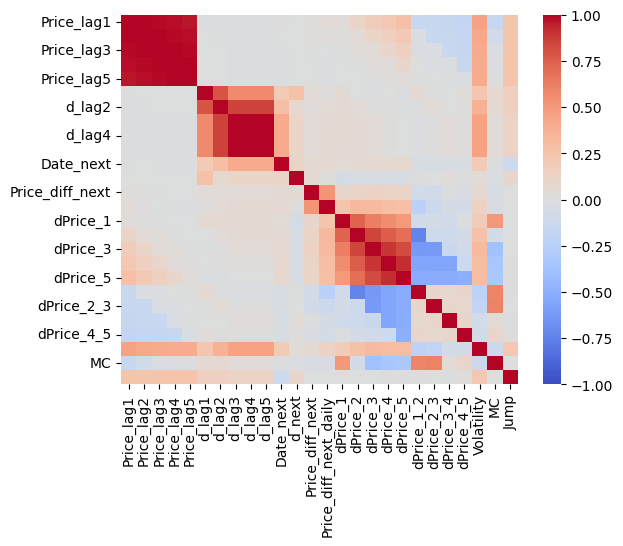

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1
)

plt.show()

According to this map, there is a strong anticorrelation when it comes to data from days 3, 4, and 5, which is maybe why it was benefitial to take 4 and 5 out of the model.

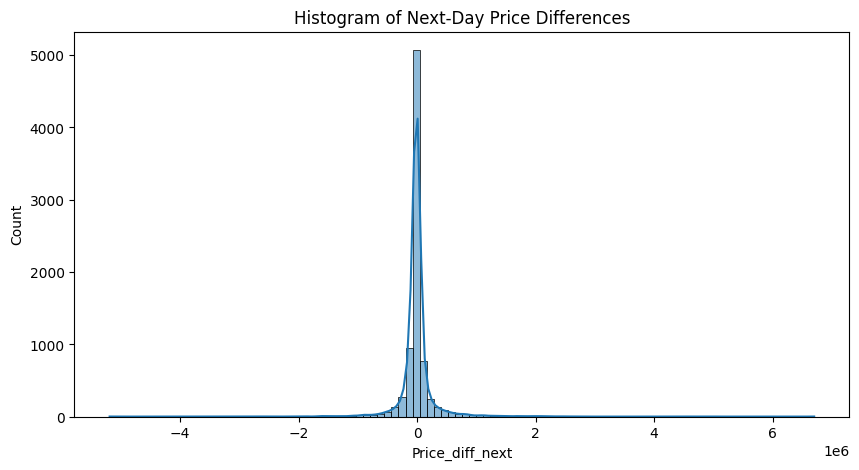

In [17]:
plt.figure(figsize=(10,5))
sns.histplot(df_t['Price_diff_next'], bins=100, kde=True)
plt.title("Histogram of Next-Day Price Differences")
plt.xlabel("Price_diff_next")
plt.ylabel("Count")
plt.show()

The target has mostly values around zero, which is small in comparison with other features such as the price, which can make it hard to predict. I think the wisest thing to do for now is to wait for more data.

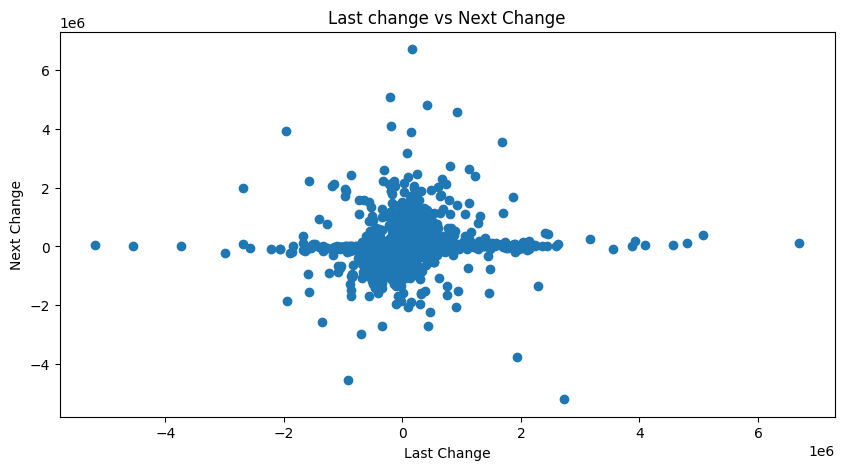

In [18]:
plt.figure(figsize=(10,5))
plt.scatter(df_t['dPrice_1'], df_t['Price_diff_next'])
plt.title("Last change vs Next Change")
plt.xlabel("Last Change")
plt.ylabel("Next Change")
plt.show()

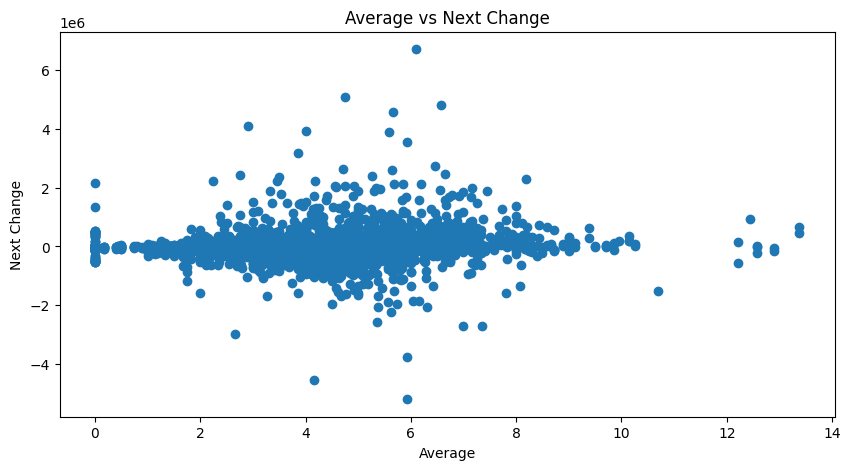

In [19]:
plt.figure(figsize=(10,5))
plt.scatter(df_t['Average'], df_t['Price_diff_next'])
plt.title("Average vs Next Change")
plt.xlabel("Average")
plt.ylabel("Next Change")
plt.show()

For now, I'll give RF a break and try with other models to test the performance. We now know there is a significant signal.

## XGBoost

Let's apply XGBoost to see if it's able to detect a stronger signal :) .

In [20]:
from xgboost import XGBRegressor

In [21]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.0,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

y_pred_xgb = xgb.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost R²: {r2_xgb:.3f}, MAE: {mae_xgb:.2f}")

importances_xgb = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("\nXGBoost feature importances:")
print(importances_xgb)

XGBoost R²: 0.002, MAE: 55835.74

XGBoost feature importances:
Team_Crystal Palace            0.070759
Team_Manchester City           0.067907
d_lag1                         0.057679
d_next                         0.057634
Team_Fulham                    0.045301
dPrice_1                       0.043571
GP                             0.042420
Price                          0.042403
Average                        0.041172
dPrice_1_2                     0.040930
Home                           0.038931
Volatility                     0.036811
Team_Chelsea                   0.036483
d_lag3                         0.034411
Team_Arsenal                   0.031945
Team_Liverpool                 0.031417
MC                             0.030036
dPrice_2_3                     0.029800
Team_Leeds United              0.029506
Team_Aston Villa               0.025191
d_lag2                         0.024811
Team_Newcastle                 0.019565
Team_Tottenham                 0.018448
Team_Manchester U